In [1]:
import os
import sys
# sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')
sys.path.append('C:/Users/USER/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path + '\\ultils')
# os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *
from plots import *

# os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core_old import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

# myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
# sns.set(style="whitegrid", font=myfont.get_name())
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\USER\Desktop\TrafficTDApython


In [3]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [119]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]
select_lst = dataA1.columns
def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 速限範圍
    dist_df = dist_df[(dist_df['速限-第1當事者'] < 200) &
                      (dist_df['當事者事故發生時年齡'] < 100) &
                      (dist_df['當事者事故發生時年齡'] > 0)]

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

car_A2 = car_A2[(car_A2['肇因研判大類別名稱-主要'] != '非駕駛者') &
                  (car_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)') &
                  (car_A2['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)')]
car_A1 = car_A1[(car_A1['肇因研判大類別名稱-主要'] != '非駕駛者') &
                  (car_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)') &
                  (car_A1['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)')] # 刪掉原因為類似於他提供不了更多資訊，但會使Mapper更加分散

car_A2 = car_A2[car_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
car_A1 = car_A1[car_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']

car_A2 = car_A2[car_A2['車輛撞擊部位大類別名稱-最初'] != '未紀錄']
car_A1 = car_A1[car_A1['車輛撞擊部位大類別名稱-最初'] != '未紀錄']


C:\Users\USER\AppData\Local\Temp\ipykernel_18424\3746701441.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_18424\3746701441.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [120]:
from sklearn.utils import resample

sampling_ratio = 0.33  # 下採樣比例

# 計算 A1 和 A2 原始數據量比例
A1_total = len(car_A1)
A2_total = len(car_A2)
total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 定義函數，按月份進行下採樣
def downsample_by_month_simple(A1, A2, sampling_ratio, total_ratio):
    A1_downsampled = pd.DataFrame()
    A2_downsampled = pd.DataFrame()

    months = sorted(set(A1['發生月份']).intersection(A2['發生月份']))  # 確保月份匹配

    for month in months:
        # 提取該月份的資料
        A1_month = A1[A1['發生月份'] == month]
        A2_month = A2[A2['發生月份'] == month]

        # 計算該月份目標數量
        A1_target = int(len(A1_month) * sampling_ratio)
        A2_target = int(A1_target / total_ratio)
        print(A1_target)
        print(A2_target)

        # 下採樣
        A1_sampled = resample(A1_month, replace=False, n_samples=A1_target, random_state=42)
        A2_sampled = resample(A2_month, replace=False, n_samples=A2_target, random_state=42)

        # 合併到最終結果
        A1_downsampled = pd.concat([A1_downsampled, A1_sampled])
        A2_downsampled = pd.concat([A2_downsampled, A2_sampled])

    return A1_downsampled.reset_index(drop=True), A2_downsampled.reset_index(drop=True)

# 下採樣
downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# Concat
rbind_data = pd.concat([downsampled_A1, downsampled_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

44
10057
45
10286
40
9143
35
8000
36
8229
39
8914
47
10743
43
9829
40
9143
47
10743


In [6]:
print(downsampled_A1.shape)
print(downsampled_A2.shape)

(416, 31)
(95087, 31)


In [121]:
bins_age = [0, 14, 24, 34, 44, 54, 64, 74, float('inf')]
labels_age = ['未滿15歲', '15~24', '25~34', '35~44', '45~54', '55~64', '65~74', '75+']

rbind_data['當事者事故發生時年齡'] = pd.cut(rbind_data['當事者事故發生時年齡'], bins=bins_age, labels=labels_age, right=False)

bins_speed = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, float('inf')]
labels_speed = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '110+']

rbind_data['速限-第1當事者'] = pd.cut(rbind_data['速限-第1當事者'], bins=bins_speed, labels=labels_speed, right=False)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
# mapper_numpy = data_to_map.to_numpy()

dummy_data: (95503, 80733)


In [463]:
rbind_data.columns

Index(['發生年度', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度', '死亡', '受傷', 'Cluster',
       '顯著特徵', 'color_for_plot'],
      dtype='object')

In [464]:
rbind_data['車輛撞擊部位大類別名稱-最初'].value_counts()

機車與自行車    54025
汽車        34576
其他         6902
Name: 車輛撞擊部位大類別名稱-最初, dtype: int64

# Kmode

In [117]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)


cost = []
all_results = {}
K = range(1, 5)

for k in K:
    
    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=10
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Best run was number 1
Best run was number 9
Best run was number 7
Best run was number 2


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [125]:
print(pd.Series(all_results[2]['labels']).value_counts())
rbind_data['Cluster'] = all_results[2]['labels']

1    48690
0    46813
dtype: int64


# MCA

In [ ]:
mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))
plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [97]:
Overlap = [2]
Interval = [11]

In [91]:
detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=10
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component7Car/results_o{overlap}i{interval}_new.pkl"
            # filename = f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/Component7Car/results_o{overlap}i{interval}.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 2, interval: 8


12/29/2024 09:25:06 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
12/29/2024 09:25:10 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
12/29/2024 09:25:17 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
12/29/2024 09:25:19 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
12/29/2024 09:25:20 AM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 142)) while a minimum of 2 is required by AgglomerativeClustering.
12/29/2024 09:25:20 AM core WARNING: Unable to perform 

Results saved to C:/Users/USER/Desktop/TrafficTDApython/Version3/Gridsearch/Component7Car/results_o2i8_new.pkl


# 國科會模型為O2I11，seed為86 (44)

In [107]:
detailed_results_df = pd.DataFrame(detailed_results)

with open('Version3/GridSearch/Component7Car/results_o2i11_new.pkl', 'rb') as f:
    detailed_results_df = pickle.load(f)

In [123]:
rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
rbind_data['顯著特徵'].unique()

array(['三岔路,無號誌,陰', '三岔路,正常,晴', '三岔路,正常,陰', '直路,無號誌,晴', '橋樑,無號誌,晴',
       '四岔路,正常,晴', '彎曲路及附近,無號誌,晴', '直路,無號誌,雨', '直路,無號誌,陰', '四岔路,不正常,晴',
       '多岔路,無號誌,雨', '地下道,無號誌,晴', '地下道,無號誌,陰', '涵洞,無號誌,晴', '直路,正常,晴',
       '三岔路,無號誌,晴', '多岔路,正常,陰', '四岔路,無號誌,晴', '坡路,無號誌,晴', '彎曲路及附近,無號誌,陰',
       '彎曲路及附近,正常,晴', '高架道路,無號誌,晴', '多岔路,正常,晴', '彎曲路及附近,無號誌,雨',
       '四岔路,正常,陰', '四岔路,無號誌,雨', '圓環,無號誌,晴', '三岔路,正常,雨', '多岔路,無號誌,晴',
       '四岔路,無號誌,陰', '隧道,無號誌,晴', '直路,正常,陰', '直路,正常,雨', '其他,無號誌,晴',
       '四岔路,正常,雨', '三岔路,無號誌,雨', '橋樑,無號誌,雨', '其他,正常,晴', '三岔路,無動作,陰',
       '高架道路,無號誌,雨', '多岔路,正常,雨', '三岔路,無動作,晴', '橋樑,無號誌,陰', '四岔路,無號誌,霧或煙',
       '三岔路,無號誌,風', '多岔路,無號誌,陰', '坡路,無號誌,陰', '地下道,正常,晴', '其他,無號誌,陰',
       '四岔路,正常,風', '直路,無號誌,霧或煙', '彎曲路及附近,無號誌,霧或煙', '坡路,無號誌,雨',
       '四岔路,無動作,晴', '橋樑,正常,晴', '圓環,正常,晴', '高架道路,正常,晴', '直路,無動作,晴',
       '地下道,無號誌,雨', '其他,正常,陰', '三岔路,正常,霧或煙', '隧道,無號誌,陰', '直路,無號誌,風',
       '隧道,正常,晴', '三岔路,無號誌,霧或煙', '三岔路,不正常,晴', '彎曲路及附近,無號誌,風', '坡路,正常,陰',
       '涵洞,無號誌,陰', '隧道,正常,陰', '高架道路,無

# 目前分析使用的模型

44

In [ ]:
choose = '天候名稱'

for i in range(86, 87):
    print(f'Seed: {i}')
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=i, iterations=200)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=15, threshold=0, range_lst=[-0.1, 0.2, 0.1, -0.15])
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)
    # mapper_plotter.plot_3d(choose, avg=False, set_label=True, size=100000)
    # mapper_plotter.plot_3d_interactive(choose, avg=False, set_label=True, size=100000,
    #                                    save_path=f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o4i8_{choose}.html")

In [ ]:
lst = ['Cluster', '車輛撞擊部位大類別名稱-最初', '當事者事故發生時年齡', '顯著特徵']
# lst = ['當事者事故發生時年齡']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=86, iterations=200)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=10, threshold=700, range_lst=[-0.075, 0.06, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i11_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
lst = ['發生月份', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃']
lst = ['肇因研判子類別名稱-個別']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=44, iterations=100)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=10, threshold=700, range_lst=[-0.25, 0.25, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                            save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i14_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
choose = '事故位置大類別名稱'

for index in range(detailed_results_df.shape[0]):

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=30, threshold=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")


# Polygon

In [189]:
# 國科會圖
rectangle1 = Polygon([(-0.03, -0.005), (-0.03, 0.05), (0.02, 0.05), (0.02, 0.04)])
rectangle2 = Polygon([(-0.025, -0.03), (-0.03, -0.005), (0.02, 0.04), (0.03, 0.03), (0.03, 0.02)])
rectangle3 = Polygon([(0, -0.04), (-0.025, -0.03), (0.03, 0.02), (0.055, 0.025), (0.05, -0.01)])
rectangle4 = Polygon([(0, -0.04), (0.05, -0.01), (0.05, -0.04), (0.02, -0.05)])

In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.03, -0.005), (-0.07, 0), (-0.05, 0.075), (0.028, 0.1), (0.02, 0.04)])
rectangle2 = Polygon([(-0.025, -0.03), (-0.07, -0.03), (-0.03, -0.005), (0.02, 0.04), (0.05, 0.05), (0.03, 0.02)])
rectangle3 = Polygon([(-0.01, -0.04), (-0.025, -0.03), (0.03, 0.02), (0.055, 0.025), (0.05, -0.0055)])
rectangle4 = Polygon([(-0.01, -0.04), (0.06, 0), (0.15, -0.1), (0, -0.075)])

# filtered_full_info = full_info[(full_info['y'] > -0.2) &
#                                (full_info['y'] < 0.1) &
#                                (full_info['x'] > -0.1) &
#                                (full_info['x'] < 0.15)]
# filtered_full_info = filtered_full_info[filtered_full_info['size'] > 0]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

模型順序
由於1，2群體在拓樸中有過渡的性質，且是從號誌到無號誌，死亡的分布有增加的趨勢，所以使用羅吉斯 <br/>
3，4群體是從這兩個群體的雨天分割出來的，在分布上可看出較類似於不同群體，因為邊的連接較少，所以使用SVM <br/>
5、6群體是離群值以及覆蓋值，分別是群體間的不相似、相似特徵，認為在空間分布上也是類似於分群，所以使用SVM

In [445]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 找出群體2和3的交集
intersection_21 = {idx for idx in count_2 if idx in count_1}

# 從交集中移除屬於群體2和3交集的資料
intersection_indexes -= intersection_21

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes and i not in intersection_21]
count_1 = [i for i in count_1 if i not in intersection_indexes and i not in intersection_21]
count_2 = [i for i in count_2 if i not in intersection_indexes and i not in intersection_21]
count_3 = [i for i in count_3 if i not in intersection_indexes and i not in intersection_21]
count_out = [i for i in count_out if i not in intersection_indexes and i not in intersection_21]

# 分群處理
full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]
full_21 = dummy_data.loc[intersection_21]
overlap_data = dummy_data.loc[intersection_indexes]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]
assert len(intersection_21) == full_21.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + full_21.shape[0] + overlap_data.shape[0])
print(dummy_data.shape[0])


C:\Users\USER\AppData\Local\Temp\ipykernel_18424\1418619427.py:42: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

C:\Users\USER\AppData\Local\Temp\ipykernel_18424\1418619427.py:43: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



95503
95503


In [446]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(full_21['死亡'].value_counts())
print(dummy_data['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

0    5358
1      18
Name: 死亡, dtype: int64
0    49645
1      202
2        2
Name: 死亡, dtype: int64
0    30617
1      118
2        3
3        1
Name: 死亡, dtype: int64
0    3312
1       9
Name: 死亡, dtype: int64
0    4013
1      40
2       4
3       2
Name: 死亡, dtype: int64
0    383
1      4
Name: 死亡, dtype: int64
0    95087
1      404
2        9
3        3
Name: 死亡, dtype: int64
0    1759
1      13
Name: 死亡, dtype: int64


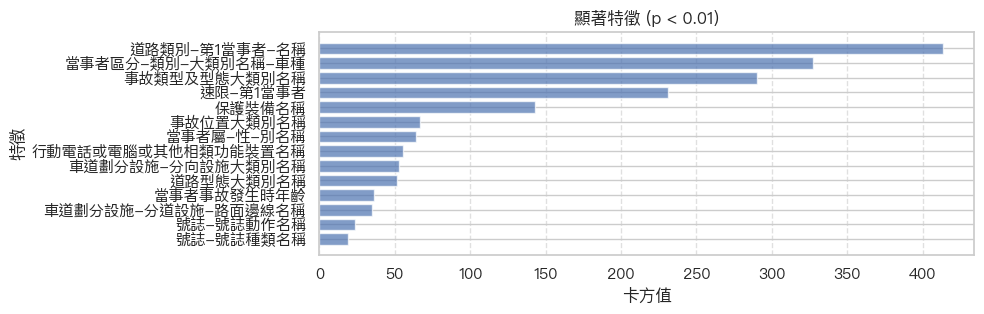

In [17]:
from scipy.stats import chi2_contingency

chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = rbind_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [447]:
full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_2 = rbind_data.loc[count_2]
full_3 = rbind_data.loc[count_3]
full_21 = rbind_data.loc[intersection_21]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[intersection_indexes]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + overlap_data.shape[0] + full_21.shape[0])
print(dummy_data.shape[0])

95503
95503


C:\Users\USER\AppData\Local\Temp\ipykernel_18424\1274087353.py:5: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.

C:\Users\USER\AppData\Local\Temp\ipykernel_18424\1274087353.py:7: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [448]:
plot_column = '道路類別-第1當事者-名稱'

data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)

categories_to_merge = ["縣道", "省道", "鄉道", "國道", "專用道路", "快速(公)道"]
comparison_df.loc["其他"] += comparison_df.loc[categories_to_merge].sum()
comparison_df = comparison_df.drop(index=categories_to_merge)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
市區道路,0.815623,0.838542,0.797033,0.805179,0.758465,0.733850,0.471052
村里道路,0.098578,0.071987,0.111097,0.099067,0.091422,0.124031,0.127371
其他,0.085799,0.089472,0.091870,0.095754,0.150113,0.142119,0.401577


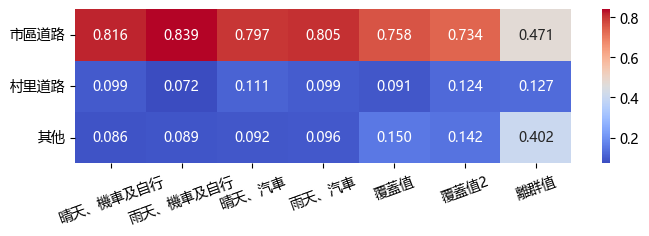

In [449]:
# heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(comparison_df.head(3), annot=True, cmap='coolwarm', fmt=".3f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

# 嚴重程度

In [502]:
def get_severity(input_data):
    """
    更新嚴重程度欄位邏輯：
    - 死亡 > 0 時，設定為 2
    - 死亡 = 0 且受傷 = 1 時，設定為 0
    - 死亡 = 0 且受傷 > 1 時，設定為 1
    """
    def severity_logic(row):
        if row['死亡'] > 0:
            return '死亡'
        elif row['死亡'] == 0 and row['受傷'] == 1:
            return '受傷1'
        elif row['死亡'] == 0 and row['受傷'] > 1:
            return '受傷1+'
        else:
            return 0

    input_data['嚴重程度'] = input_data.apply(severity_logic, axis=1)
    return input_data

full_0_s = get_severity(full_0)
full_1_s = get_severity(full_1)
full_2_s = get_severity(full_2)
full_3_s = get_severity(full_3)
full_21_s = get_severity(full_21)
full_out_s = get_severity(full_out)
overlap_data_s = get_severity(overlap_data)

In [504]:
plot_column = '嚴重程度'

data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=False),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=False),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=False),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=False),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=False),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=False),
    "離群值": full_out[plot_column].value_counts(normalize=False),
    
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
Total,49849,5376,30739,3321,1772,387,4059
受傷1,30113,3871,26501,2840,1321,298,2875
受傷1+,19532,1487,4116,472,438,85,1138
死亡,204,18,122,9,13,4,46


In [505]:
data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
# total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
Total,49849.000000,5376.000000,30739.000000,3321.000000,1772.000000,387.000000,4059.000000
受傷1,0.604084,0.720052,0.862130,0.855164,0.745485,0.770026,0.708303
受傷1+,0.391823,0.276600,0.133902,0.142126,0.247178,0.219638,0.280365
死亡,0.004092,0.003348,0.003969,0.002710,0.007336,0.010336,0.011333


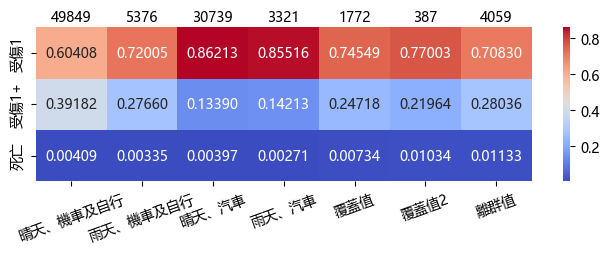

In [506]:
total_row = comparison_df.loc["Total"]

# 提取僅包含數值的列，並移除 Total 行
numeric_df = comparison_df.select_dtypes(include=[float, int]).drop("Total")

# 繪製 heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(numeric_df.tail(3), annot=True, cmap='coolwarm', fmt=".5f")

# 添加總數標註在每個欄位的頂部
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

# 調整外觀
plt.xticks(rotation=20)
plt.show()


# 雨天影響

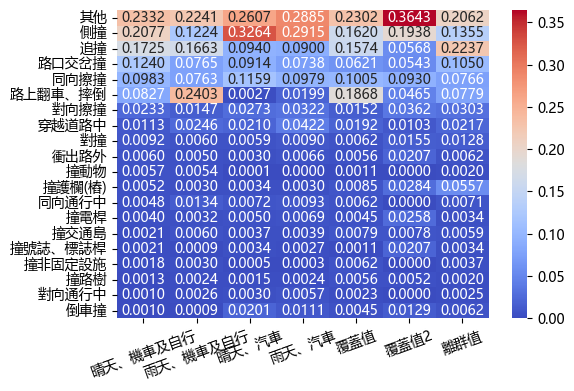

In [508]:
plot_column = '事故類型及型態子類別名稱'

data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}
# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
# comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='晴天、機車及自行', axis=0, ascending=False)

# heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(comparison_df.head(20), annot=True, cmap='coolwarm', fmt=".4f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

In [288]:
full_1.columns

Index(['發生年度', '發生日期', '發生時間', '事故類別名稱', '處理單位名稱警局層', '發生地點', '天候名稱', '光線名稱',
       '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '當事者順位',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態子類別名稱', '車輛撞擊部位大類別名稱-最初',
       '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他', '肇因研判大類別名稱-個別',
       '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃', '經度', '緯度', '死亡', '受傷', 'Cluster',
       '顯著特徵', 'color_for_plot', '嚴重程度'],
      dtype='object')

In [495]:
plot_column = '車道劃分設施-分道設施-快慢車道間名稱'

data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=False),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=False),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=False),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=False),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=False),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=False),
    "離群值": full_out[plot_column].value_counts(normalize=False),
}
# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
# comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='晴天、機車及自行', axis=0, ascending=False)

comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
未繪設快慢車道分隔線,40745,4219,24476,2664,1154,336,3426
快慢車道分隔線,7953,950,5527,561,481,39,480
寬式快慢車道分隔島(50公分以上),828,155,585,77,110,6,120
窄式快慢車道分隔島(無柵欄),227,37,113,13,20,4,22
窄式快慢車道分隔島(附柵欄),96,15,38,6,7,2,11


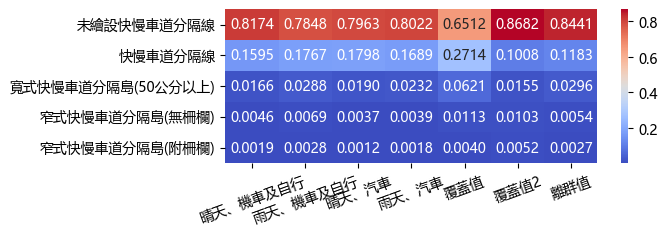

In [496]:
data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}
# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
# comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='晴天、機車及自行', axis=0, ascending=False)

# heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(comparison_df.head(10), annot=True, cmap='coolwarm', fmt=".4f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

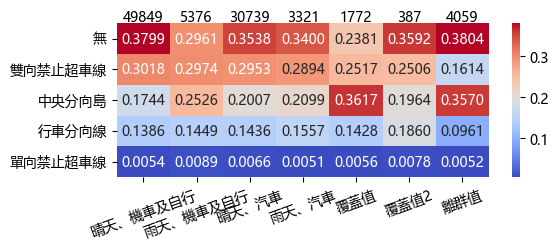

In [472]:

plot_column = '車道劃分設施-分向設施大類別名稱'

data_dict = {
    "晴天、機車及自行": full_1[plot_column].value_counts(normalize=False),
    "雨天、機車及自行": full_0[plot_column].value_counts(normalize=False),
    "晴天、汽車": full_2[plot_column].value_counts(normalize=False),
    "雨天、汽車": full_3[plot_column].value_counts(normalize=False),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=False),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=False),
    "離群值": full_out[plot_column].value_counts(normalize=False),
}
total_row = pd.DataFrame(data_dict).fillna(0).sum(axis=0)

# heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(comparison_df.head(10), annot=True, cmap='coolwarm', fmt=".4f")
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

plt.xticks(rotation=20)
plt.show()

# 分類模型

In [ ]:
def get_train_test_data(input_data):
    input_data['y'] = input_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)
    
    new_input_data = input_data.drop(columns=['受傷', '死亡'], inplace=False)
    
    X = new_input_data.drop(columns=['y'])
    y = new_input_data['y']

    return X, y

X0, y0 = get_train_test_data(full_0)
X1, y1 = get_train_test_data(full_1)
X2, y2 = get_train_test_data(full_2)
X3, y3 = get_train_test_data(full_3)
Xout, yout = get_train_test_data(full_out)
Xfull, yfull = get_train_test_data(dummy_data)
Xoverlap, yoverlap = get_train_test_data(overlap_data)

In [ ]:
matrix_0, score_0, cm_0, decision_scores_0 = logistic_cm_gridsearch(X0, y0, threshold=0.5)
matrix_1, score_1, cm_1, decision_scores_1 = logistic_cm_gridsearch(X1, y1, threshold=0.5)
matrix_2, score_2, cm_2, decision_scores_2 = logistic_cm_gridsearch(X2, y2, threshold=0.5)
matrix_3, score_3, cm_3, decision_scores_3 = logistic_cm_gridsearch(X3, y3, threshold=0.5)
matrix_out, score_out, cm_out, decision_scores_out = logistic_cm_gridsearch(Xout, yout, threshold=0.5)
matrix_overlap, score_overlap, cm_overlap, decision_scores_overlap = logistic_cm_gridsearch(Xoverlap, yoverlap, threshold=0.5)

print(matrix_0)
print(matrix_1)
print(matrix_2)
print(matrix_3)
print(matrix_out)
print(matrix_overlap)

In [ ]:
matrix_0, score_0, cm_0, decision_scores_0 = linear_svc_cm_gridsearch(X0, y0, threshold=-1.8)
matrix_1, score_1, cm_1, decision_scores_1 = linear_svc_cm_gridsearch(X1, y1, threshold=-1.8)
matrix_2, score_2, cm_2, decision_scores_2 = linear_svc_cm_gridsearch(X2, y2, threshold=-1.8)
matrix_3, score_3, cm_3, decision_scores_3 = linear_svc_cm_gridsearch(X3, y3, threshold=-1.8)
matrix_out, score_out, cm_out, decision_scores_out = linear_svc_cm_gridsearch(Xout, yout, threshold=-1.8)
matrix_overlap, score_overlap, cm_overlap, decision_scores_overlap = linear_svc_cm_gridsearch(Xoverlap, yoverlap, threshold=-1.8)

print(cm_2)
print(cm_3)
print(cm_out)
print(cm_overlap)

total_cm = cm_2 + cm_3 + cm_out + cm_overlap

total_correct = total_cm[0, 0] + total_cm[1, 1]  # True positives + True negatives
total_samples = total_cm.sum()  # Total samples
accuracy = total_correct / total_samples

print(total_cm, accuracy)

In [ ]:
full_svc_matrix, full_svc_score, full_svc_cm, full_svc_decision_scores = linear_svc_cm_gridsearch(Xfull, yfull, threshold=-1.5)
full_logit_matrix, full_logit_score, full_logit_cm, full_logit_decision_scores = logistic_cm_gridsearch(Xfull, yfull, threshold=0.5)